# Price Analysis with Dynamic Balance Tracking and Trading Strategy

In [1]:

# Content of trading_strategy.py
import numpy as np

class GridBotStrategy:
    def __init__(self, config):
        self.grid_levels = int(config['grid_levels'])
        self.grid_size = float(config['grid_size'])
        self.order_size = int(config['order_size'])
        self.orders = []

    def execute(self, data):
        current_price = data['price']
        self.orders = []
        for i in range(1, self.grid_levels + 1):
            self.orders.append({
                'type': 'buy',
                'price': current_price - (i * self.grid_size),
                'size': self.order_size
            })
            self.orders.append({
                'type': 'sell',
                'price': current_price + (i * self.grid_size),
                'size': self.order_size
            })
        print(f"GridBot orders: {self.orders}")

class TrendFollowingStrategy:
    def __init__(self, config):
        self.ma_period = int(config['moving_average_period'])
        self.rsi_period = int(config['rsi_period'])
        self.rsi_overbought = int(config['rsi_overbought'])
        self.rsi_oversold = int(config['rsi_oversold'])
        self.prices = []

    def moving_average(self, prices):
        return np.mean(prices[-self.ma_period:])

    def calculate_rsi(self, prices):
        if len(prices) < self.rsi_period + 1:
            return 50  # Neutral RSI when insufficient data
        deltas = np.diff(prices[-(self.rsi_period + 1):])
        gains = deltas[deltas > 0].sum()
        losses = -deltas[deltas < 0].sum()
        if losses == 0:
            return 100
        rs = gains / losses
        return 100 - (100 / (1 + rs))

    def detect_trend(self, prices):
        if len(prices) < self.ma_period:
            return "stable"  # Not enough data to determine trend
        ma = self.moving_average(prices)
        recent_price = prices[-1]
        if recent_price > ma * 1.01:  # 1% threshold for growing
            return "growing"
        elif recent_price < ma * 0.99:  # 1% threshold for falling
            return "falling"
        else:
            return "stable"

    def execute(self, data):
        self.prices.append(data['price'])
        if len(self.prices) < self.ma_period:
            return  # Not enough data for moving average
        ma = self.moving_average(self.prices)
        rsi = self.calculate_rsi(self.prices)
        trend = self.detect_trend(self.prices)
        print(f"TrendFollowing - MA: {ma}, RSI: {rsi}, Trend: {trend}")
        if trend == "growing" and rsi < self.rsi_oversold:
            print("Buy Signal")
        elif trend == "falling" and rsi > self.rsi_overbought:
            print("Sell Signal")


TrendFollowing - MA: 31.140468311309814, RSI: 67.89667919915894, Trend: growing
Buy executed: 295.8730214625999 units at 33.798282623291016
TrendFollowing - MA: 31.2097638130188, RSI: 61.01084055585264, Trend: growing
Buy executed: 273.89386417729656 units at 32.85944366455078
TrendFollowing - MA: 31.442238903045656, RSI: 62.886609425133834, Trend: growing
Buy executed: 241.57438820437557 units at 33.53004455566406
TrendFollowing - MA: 31.53612298965454, RSI: 60.42402475271705, Trend: growing
Buy executed: 218.58273891230303 units at 33.35121536254883
TrendFollowing - MA: 31.806598663330078, RSI: 59.85663203016238, Trend: growing
Buy executed: 192.84684718423208 units at 34.02181625366211
TrendFollowing - MA: 32.11731033325195, RSI: 63.636361117852324, Trend: growing
Buy executed: 165.93065985650247 units at 35.586551666259766
TrendFollowing - MA: 32.53308296203613, RSI: 66.76558201597416, Trend: growing
Buy executed: 140.67777168718118 units at 37.77718353271485
TrendFollowing - MA: 3

/tmp/ipykernel_11157/3249107879.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99722.22288061073' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[i, 'Account Balance'] = account_balance + (held_quantity * row['Close'])


TrendFollowing - MA: 23.13376235961914, RSI: 35.05060411436544, Trend: falling
Sell executed: 4.707472674742993 units at 20.81545066833496
TrendFollowing - MA: 22.94134464263916, RSI: 32.71767581077091, Trend: falling
Sell executed: 2.3537363373714966 units at 20.39341926574707
TrendFollowing - MA: 22.71423444747925, RSI: 21.3812783833051, Trend: falling
Sell executed: 1.1768681686857483 units at 19.921316146850582
TrendFollowing - MA: 22.535765171051025, RSI: 12.47378596490151, Trend: falling
Sell executed: 0.5884340843428741 units at 19.89270401000977
TrendFollowing - MA: 22.4234619140625, RSI: 30.000007017036637, Trend: falling
Sell executed: 0.29421704217143707 units at 21.48784065246582
TrendFollowing - MA: 22.301501941680907, RSI: 24.552845387455932, Trend: falling
Sell executed: 0.14710852108571854 units at 20.557939529418945
TrendFollowing - MA: 22.144134330749512, RSI: 25.506759533826497, Trend: falling
Sell executed: 0.07355426054285927 units at 19.992847442626957
TrendFollow

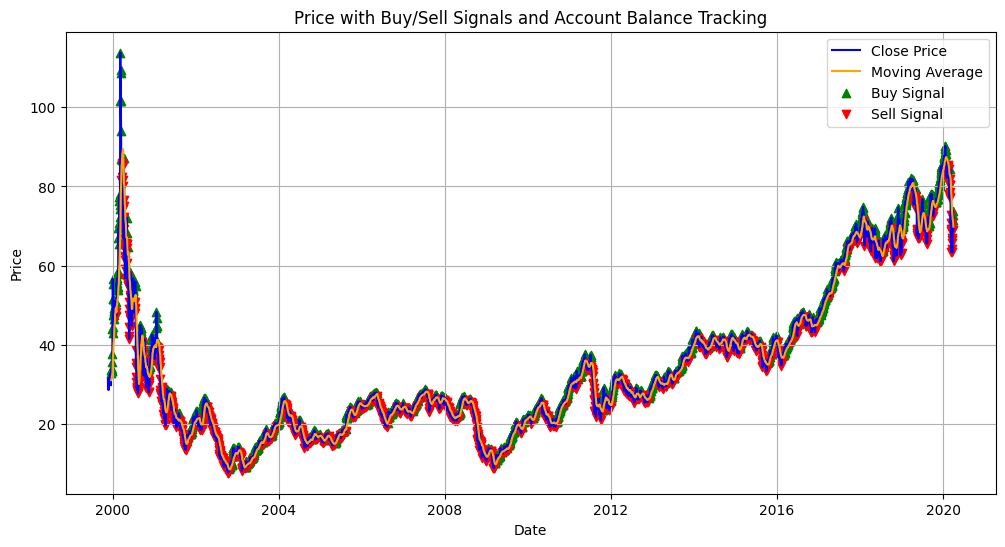

Final account balance: $251033.96
Final held quantity: 545.4555836466526 units


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from trading_strategy import GridBotStrategy, TrendFollowingStrategy

# Load the data
data = pd.read_csv('test_data.csv')

# Ensure proper formatting
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Configuration
starting_balance = 100000  # Initial account balance in dollars
account_balance = starting_balance
held_quantity = 0  # Amount of the asset held
strategy_config = {
    'grid_bot': {
        'grid_levels': 10,
        'grid_size': 0.001,
        'order_size': 100,
    },
    'trend_following': {
        'moving_average_period': 20,
        'rsi_period': 14,
        'rsi_overbought': 70,
        'rsi_oversold': 30,
    },
}

# Initialize the strategy
trend_strategy = TrendFollowingStrategy(strategy_config['trend_following'])

# Apply the strategy to the data and log balance
data['Signal'] = None
data['Trend'] = None
data['Account Balance'] = account_balance

for i, row in data.iterrows():
    trend_strategy.execute({'price': row['Close']})
    trend = trend_strategy.detect_trend(data['Close'][:i+1])
    data.at[i, 'Signal'] = trend

    # Execute trades based on signals
    if trend == "growing" and account_balance > 0:
        # Buy signal: Calculate how much to buy
        buy_amount = account_balance * 0.1  # Allocate 10% of the balance
        buy_quantity = buy_amount / row['Close']
        account_balance -= buy_amount
        held_quantity += buy_quantity
        print(f"Buy executed: {buy_quantity} units at {row['Close']}")

    elif trend == "falling" and held_quantity > 0:
        # Sell signal: Calculate how much to sell
        sell_quantity = held_quantity * 0.5  # Sell 50% of held quantity
        sell_amount = sell_quantity * row['Close']
        account_balance += sell_amount
        held_quantity -= sell_quantity
        print(f"Sell executed: {sell_quantity} units at {row['Close']}")

    # Log balance after each iteration
    data.at[i, 'Account Balance'] = account_balance + (held_quantity * row['Close'])

# Plot the data with signals
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
data['MA'] = data['Close'].rolling(window=strategy_config['trend_following']['moving_average_period']).mean()
plt.plot(data['Date'], data['MA'], label='Moving Average', color='orange')

# Add buy/sell markers based on the strategy
buy_signals = data[data['Signal'] == 'growing']
sell_signals = data[data['Signal'] == 'falling']

plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', color='green', marker='^', alpha=1)
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', color='red', marker='v', alpha=1)

plt.title('Price with Buy/Sell Signals and Account Balance Tracking')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Display final account balance
print(f"Final account balance: ${account_balance:.2f}")
print(f"Final held quantity: {held_quantity} units")
